In [2]:
from util.util import get_device
device = get_device()

import torch
import model.diffusion as gd
import model.vae as mv
from model.classifier.logp_predictor import LogPPredictor
from model.guidance import get_cond_fn, get_cond_fn_normal_analytical
from util.chem import calculate_logp, selfies_to_smiles
from util.stats import is_different_from_other
import util.visualization as vis

from torch.distributions import Normal

DIFFUSION_PATH = "saved_models/diffusion/molecule-diffusion-v1.pt"
VAE_PATH = "saved_models/selfies_vae/selfies-vae.ckpt"
LOGP_PREDICTOR_PATH = "saved_models/logp/model-logp"

/home/alden/miniconda3/envs/pytorch-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Create diffusion model, vae
diffusion = gd.create_diffusion_model(model_path=DIFFUSION_PATH, device=device)
vae = mv.load_vae_selfies(path_to_vae_statedict=VAE_PATH)
logp_predictor : LogPPredictor = torch.load(LOGP_PREDICTOR_PATH, weights_only=False).to(device)


Model created successfully
- Total parameters: 57,314,049
- Trainable parameters: 57,314,049
- Model size: 218.6 MB
- Device: cuda:0
- Model Name: LatentDiffusionModel


/home/alden/Research/GDProject/model/diffusion/load.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


loading model from saved_models/selfies_vae/selfies-vae.ckpt
Enc params: 1,994,592
Dec params: 277,346


/home/alden/Research/GDProject/model/vae/util.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_to_vae_statedict, map_location=device)["state

In [3]:
z_diffusion = diffusion.sample(batch_size=64)

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.07it/s]


In [11]:
# utility functions:
def latent_to_logp(z, vae=vae, invalid_token=0.0):
    smiles = mv.latent_to_smiles(z=z, vae=vae)
    return calculate_logp(smiles=smiles, invalid_token=invalid_token)

def display_logp_info(z, show_histogram=True, show_molecule=True):
    # LogPs 
    logps_gd = latent_to_logp(z)
    z_vae = torch.randn(64, 128)
    logps_vae = latent_to_logp(z_vae) # sample from VAE prior
    logps_diffusion_cached = latent_to_logp(z_diffusion)

    if show_histogram:
        vis.display_histograms([logps_gd, logps_vae, logps_diffusion_cached], ['Guided Diffusion LogPs', 'VAE Prior LogPs', 'Cached Diffusion LogPs'])

    # Example of one of the guided diffusion moleculee:
    if show_molecule:
        smiles_gd = mv.latent_to_smiles(z, vae=vae)
        vis.display_molecule(smiles_string=smiles_gd[0], title='Guided Diffusion Output')

    # you would not believe me but I actually wrote this not claude for once lmao

    print(f"Max LogP: {max(logps_gd)}")
    print(f"Min LogP: {min(logps_gd)}")
    print(f"Avg LogP: {sum(logps_gd) / len(logps_gd)}")

    print("--------------------------------------------------")
    print("Statistics: ")
    is_different_from_other(z, z_diffusion)

**Test #1** 

Can diffusion get all latent values to ~0.5

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [00:09<00:00, 102.96it/s]


Sample of shape: torch.Size([16, 1, 128]) is different from other with p=0.0000


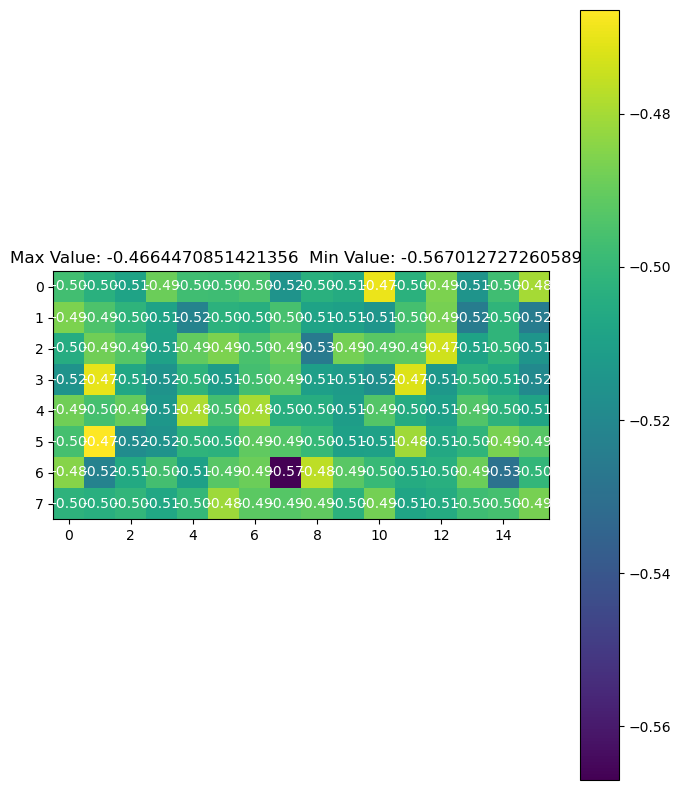

In [5]:
# Test Diffusion Can get all latent values to be 0.5

cond_fn_normal_dist = get_cond_fn_normal_analytical(mean=-0.5, sigma=0.01)
z = diffusion.sample(batch_size=16, cond_fn=cond_fn_normal_dist)
is_different_from_other(z, z_diffusion, alpha=0.01)

# Should be normal centered around 0.2
vis.display_latent(z[0])


DDPM Sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 40.96it/s]


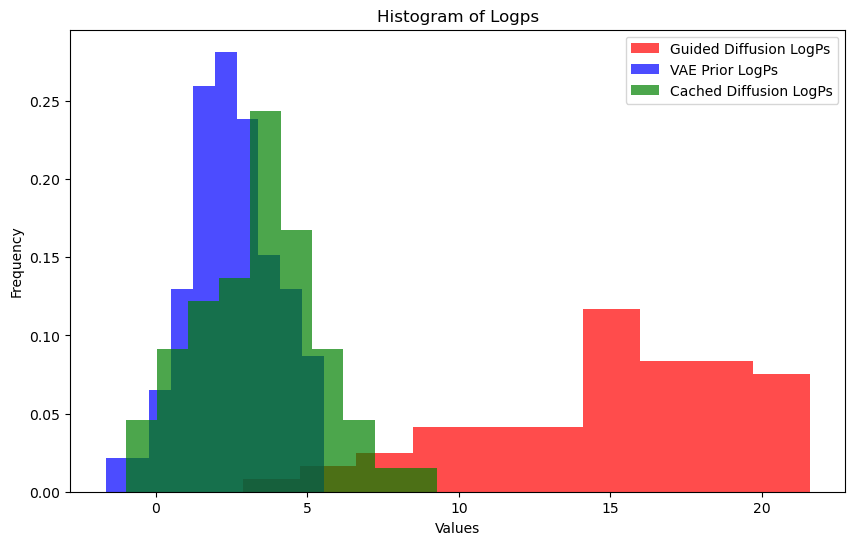

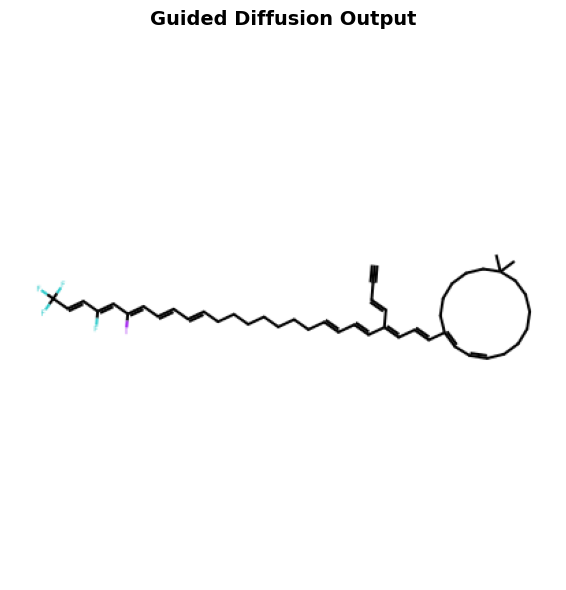

SMILES: C1CCCCC(C)(C)CCCCCCC=CC=C1C=CC=C(C=CC=CCCCCCCCC=CC=CC=C(I)C=C(F)C=CC(F)(F)F)C=CC#C
Max LogP: 21.59520000000001
Min LogP: 2.8743000000000016
Avg LogP: 14.946912499999979
--------------------------------------------------
Statistics: 
Sample of shape: torch.Size([64, 1, 128]) is different from other with p=0.0000
Minimum VAE Value: -5.610583782196045
Maximum VAE Value: 4.010341167449951


In [14]:
# Diffusion shape test (Test #2)
logp_distribution = Normal(loc=100.0, scale=1.0)

# log probability function that gives the probability of the logps of z
# under the logp_distribution

def log_prob_fn_logp(z):
    # We cant backprop thru the evaluate_logp function, so we 
    # instead have this predictor trained on latent, logp pairs:
    pred_logp = logp_predictor(z)

    # get the log_probability under the normal distribution with mean=20.0
    log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)

    # the log probability must be a single value
    assert(log_prob.shape == (1, ))
    return log_prob


# Pass random data through to check shapes work
z_random = torch.randn(16, 1, 128, device=device)

cond_fn_logp = get_cond_fn(
    log_prob_fn=log_prob_fn_logp, 
    guidance_strength=1.0, 
    clip_grad=True, 
    clip_grad_max=1.0,
)

grad_log_prob = cond_fn_logp(mean = z_random, t = 0)
assert(z_random.shape == grad_log_prob.shape)

# Now pass real data through
z = diffusion.sample(batch_size=64, cond_fn=cond_fn_logp)
display_logp_info(z)

print(f"Minimum VAE Value: {z.flatten().min()}")
print(f"Maximum VAE Value: {z.flatten().max()}")


** BAYESOPT SECTION **

In [7]:
import gpytorch
from dataclasses import dataclass
from botorch.optim import optimize_acqf
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll_torch
from botorch.acquisition import qLogExpectedImprovement, LogExpectedImprovement
from gpytorch.mlls import PredictiveLogLikelihood, ExactMarginalLogLikelihood

from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from botorch.models.approximate_gp import SingleTaskVariationalGP
from botorch.models import SingleTaskGP
from gpytorch.priors import LogNormalPrior
from botorch.utils.transforms import normalize, unnormalize
from torch.optim import SGD



In [8]:

LATENT_DATASET_LOCATION = "data/latents_pair_dataset_1"
LOGP_LABEL_DATASET_LOCATION = "data/logp_pair_dataset_1"

X_all_data = torch.load(LATENT_DATASET_LOCATION, weights_only=True)
Y_all_data = torch.load(LOGP_LABEL_DATASET_LOCATION, weights_only=True)

def get_initial_data(num_initial_datapoints=100):
    Xs = X_all_data[:num_initial_datapoints].reshape(-1,128).clone().double().to(device)
    Ys = Y_all_data[:num_initial_datapoints].reshape(-1,1).clone().double().to(device)
    return Xs, Ys


In [9]:
vae = vae.double().to(device)
obj_func = lambda smiles : calculate_logp(smiles, invalid_token=0.0)

d = 128
bounds = torch.tensor([[-5.0] * d, [5.0] * d], device=device, dtype=torch.float64)
unit_bounds = torch.tensor([[0.0] * d, [1.0] * d], device=device, dtype=torch.float64)


In [20]:
is_normalized = True

X, Y = get_initial_data(num_initial_datapoints=100) # X.shape (100, 128) Y.shape (100, 1)

if is_normalized:
    X = normalize(X, bounds=bounds)

state_dict = None
model = SingleTaskGP(train_X=X, train_Y=Y)

def get_model():
    return SingleTaskGP(train_X=X, train_Y=Y)

def fit_model(model, num_epochs=10, show_epoch_num=True):
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    model.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, model.train_targets)
        loss.backward()

        if (epoch + 1) % 10 == 0 and show_epoch_num:
            print(f"Epoch {epoch+1:>3}/{num_epochs} - Loss: {loss.item():>4.3f} ")
        
        optimizer.step()

model = get_model()
optimizer = SGD([{"params": model.parameters()}], lr=0.025)

def generate_batch(model, batch_size=10, num_restarts=10, raw_samples=512, sequential=True):
    ei = qLogExpectedImprovement(model, best_f=Y.max())

    acqf_bounds = unit_bounds if is_normalized else bounds
    X_next, acq_value = optimize_acqf(
        ei,
        q=batch_size,
        bounds=acqf_bounds,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        sequential=sequential
    )
    
    return X_next
    
# initial fit
fit_model(model, num_epochs=2000, show_epoch_num=False)

for epoch in range(10):
    model = get_model()

    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    fit_model(model)

    X_next = generate_batch(model, batch_size=10, num_restarts=10, raw_samples=512, sequential=False)

    X_next_unormalized = unnormalize(X_next, bounds=bounds) if is_normalized else X_next

    # X_next_unormalized = self._generate_batch_diffusion(batch_size=acqf_batch_size)
    Y_next_list = latent_to_logp(X_next_unormalized, vae=vae, invalid_token=0.0)
    Y_next = torch.tensor(Y_next_list, dtype=Y.dtype, device=device).reshape(-1, 1)

    # X_next = normalize(X_next_unormalized, bounds=bounds)
    X = torch.cat([X, X_next])
    Y = torch.cat([Y, Y_next])

    state_dict = model.state_dict()


    print(f"{len(X)}) Best value: {Y.max():.5f}")



Epoch  10/10 - Loss: 8.962 
110) Best value: 15.40398
Epoch  10/10 - Loss: 6.825 
120) Best value: 98.26300
Epoch  10/10 - Loss: 5.483 
130) Best value: 98.26300
Epoch  10/10 - Loss: 8.111 


KeyboardInterrupt: 

In [ ]:
print

In [25]:

class BayesOptModel:
    def __init__(self, is_normalized=False, state_dict=None):
        self.X, self.Y = get_initial_data(num_initial_datapoints=1000)
        self.is_normalized = True
        if self.is_normalized:
            self.X = normalize(self.X, bounds=bounds)

        self.state_dict = None if not state_dict else state_dict
        self.model = self.get_model()

        self.optimizer = SGD([{"params": self.model.parameters()}], lr=0.025)

    def get_model(self):
        '''User-defined function which defines the model'''
        return SingleTaskGP(train_X=self.X, train_Y=self.Y)
    
    def get_ei(self):
        '''User-defined function which defines the EI function'''
        return qLogExpectedImprovement(self.model, best_f=self.Y.max())

    def get_mll(self):
        '''User-defined function which defines the MLL function'''
        return ExactMarginalLogLikelihood(self.model.likelihood, self.model)
    
    def fit_inital(self, num_epochs=100):
        self._fit_model(num_epochs=num_epochs)
        self.state_dict = self.model.state_dict()

    def train(self, num_epochs=10, initial_fit_num_epochs=100, model_fit_num_epochs=10, acqf_batch_size=10):
        # initial fitting
        self.fit_inital(initial_fit_num_epochs)
        
        for epoch in range(num_epochs):
            self.model = self.get_model()

            if self.state_dict is not None:
                self.model.load_state_dict(self.state_dict)

            self._fit_model()
            
            X_next = self._generate_batch(batch_size=acqf_batch_size, num_restarts=10, raw_samples=512, sequential=False)
            X_next_unormalized = unnormalize(X_next, bounds=bounds) if self.is_normalized else X_next

            # X_next_unormalized = self._generate_batch_diffusion(batch_size=acqf_batch_size)
            Y_next_list = latent_to_logp(X_next_unormalized, vae=vae, invalid_token=0.0)
            Y_next = torch.tensor(Y_next_list, dtype=self.Y.dtype, device=device).reshape(-1, 1)

            # X_next = normalize(X_next_unormalized, bounds=bounds)
            self.X = torch.cat([self.X, X_next])
            self.Y = torch.cat([self.Y, Y_next])

            self.state_dict = self.model.state_dict()


            print(f"{len(self.X)}) Best value: {self.Y.max():.5f}")

    # def guide_diffusion(self):
    #     self.model = self.get_model()

    #     if self.state_dict is not None:
    #         self.model.load_state_dict(self.state_dict)

    #     X_next_unorm = self._generate_batch_diffusion(batch_size=4)

    #     Y_next_list = latent_to_logp(X_next_unorm, vae=vae, invalid_token=0.0)
    #     Y_next = torch.tensor(Y_next_list, dtype=self.Y.dtype, device=device).reshape(-1, 1)
    #     print(f"Batch Max: {Y_next.max()}")
    #     print(f"Batch Mean: {Y_next.mean()}")
    #     print(f"Batch Min: {Y_next.min()}")


    def _fit_model(self, num_epochs=10, show_epoch_num=False):
        mll = self.get_mll()
        self.model.train()

        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            output = self.model(self.X)
            loss = -mll(output, self.model.train_targets)
            loss.backward()

            if (epoch + 1) % 10 == 0 and show_epoch_num:
                print(f"Epoch {epoch+1:>3}/{10} - Loss: {loss.item():>4.3f} ")

            self.optimizer.step()

    def _update_model(self):
        pass

    def _get_qei_fn(self, best=None):
        with torch.no_grad():
            best_f = self.Y.max() if best is None else best
            EI = qLogExpectedImprovement(self.model, best_f=best_f)

        # probably should be under
        def log_probability_fn_with_ei(mean):
            mean = mean.to('cuda')
            # mean is unnormalized:
            mean = normalize(mean, bounds=bounds)
            ei_val = EI(mean)
            return ei_val
        return log_probability_fn_with_ei
    
    def _get_ei_fn(self, best=None):
        with torch.no_grad():
            best_f = self.Y.max() if best is None else best
            EI = LogExpectedImprovement(self.model, best_f=best_f)

        def log_probability_fn_with_ei(mean):
            mean = mean.to('cuda')
            # mean = normalize(mean, bounds=bounds)
            ei_val = EI(mean.reshape(-1, 1, 128)).sum()
            return ei_val
        return log_probability_fn_with_ei

    def _generate_batch(self, batch_size=10, num_restarts=10, raw_samples=512, sequential=True):
        print("Generating Batch...")
        ei = self.get_ei()

        acqf_bounds = unit_bounds if self.is_normalized else bounds
        X_next, acq_value = optimize_acqf(
            ei,
            q=batch_size,
            bounds=acqf_bounds,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
            sequential=sequential
        )
        
        return X_next
    
    # def _generate_batch_diffusion(self, batch_size=4, guidance_strength=1.0):
    #     # return torch.randn(batch_size, 128, dtype=torch.float64, device=device)
    #     z = diffusion.sample(batch_size=batch_size, cond_fn=get_cond_fn(log_prob_fn=self._get_qei_fn(best=0.0), guidance_strength=10.0), guidance_kwargs={})
    #     z = z.double().reshape(-1, 128).to(device)
    #     return z


In [26]:
bayesopt = BayesOptModel()

In [27]:
bayesopt.train()


Generating Batch...
1010) Best value: 10.41380
Generating Batch...
1020) Best value: 17.65620
Generating Batch...


KeyboardInterrupt: 